In [22]:
import numpy as np 
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

import torch 
import torch.nn as nn
import torch.optim as optim 

from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import root_mean_squared_error

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [24]:
ticker = input("Enter stock ticker symbol: ").upper()
df = yf.download(ticker, '2020-01-01')

[*********************100%***********************]  1 of 1 completed


In [25]:
df

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2020-01-02,72.468269,72.528589,71.223267,71.476607,135480400
2020-01-03,71.763718,72.523746,71.539330,71.696160,146322800
2020-01-06,72.335556,72.374162,70.634539,70.885472,118387200
2020-01-07,71.995354,72.600960,71.775789,72.345204,108872000
2020-01-08,73.153496,73.455095,71.698581,71.698581,132079200
...,...,...,...,...,...
2025-12-19,273.670013,274.600006,269.899994,272.149994,144632000
2025-12-22,270.970001,273.880005,270.510010,272.859985,36571800


<Axes: xlabel='Date'>

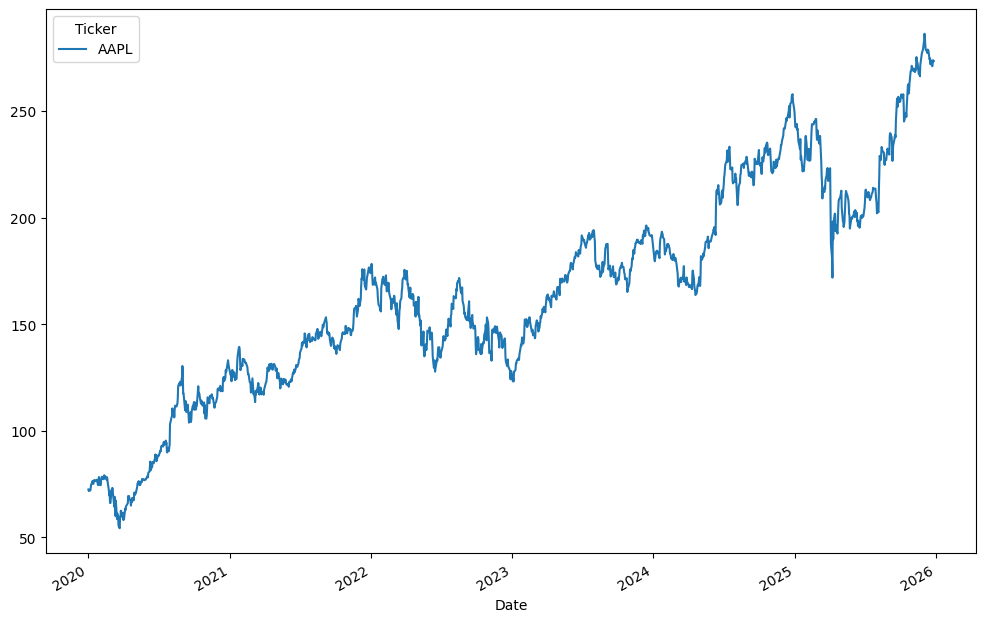

In [26]:
df.Close.plot(figsize=(12,8))

In [27]:
scaler = StandardScaler()

df['Close'] = scaler.fit_transform(df['Close'])

In [28]:
df.Close


Ticker,AAPL
Date,
2020-01-02,-1.863155
2020-01-03,-1.877384
2020-01-06,-1.865835
2020-01-07,-1.872706
2020-01-08,-1.849317
...,...
2025-12-19,2.200117
2025-12-22,2.145591
2025-12-23,2.173661


In [29]:
seq_length = 30 
data = []

for i in range(len(df)-seq_length):
    data.append(df.Close[i:i+seq_length])

data = np.array(data)

train_size = int(0.8*len(data))

x_train = torch.from_numpy(data[:train_size, :-1, :]).type(torch.Tensor).to(device)
y_train = torch.from_numpy(data[:train_size, -1, :]).type(torch.Tensor).to(device)
x_test = torch.from_numpy(data[train_size:, :-1, :]).type(torch.Tensor).to(device)
y_test = torch.from_numpy(data[train_size:, -1, :]).type(torch.Tensor).to(device)

In [31]:
class PredictionModel(nn.Module):

    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(PredictionModel, self).__init__()

        self.num_layers = num_layers
        self.hidden_dim = hidden_dim

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True,)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=device)

        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:,-1,:])

        return out


In [ ]:
# create model
model = PredictionModel(input_dim = 1, hidden_dim=32, num_layers=2, output_dim=1).to(device)

In [33]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [34]:
num_epochs = 200

for i in range(num_epochs):
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train)

    if i % 25 == 0 :
        print(i, loss.item())       
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


0 0.7827702164649963
25 0.009146902710199356
50 0.0056059155613183975
75 0.004664931446313858
100 0.00434620026499033
125 0.004119848366826773
150 0.003920338116586208
175 0.003737996332347393


In [35]:
model.eval()

y_test_pred = model(x_test)

y_train_pred = scaler.inverse_transform(y_train_pred.detach().cpu().numpy())
y_train = scaler.inverse_transform(y_train.detach().cpu().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().cpu().numpy())
y_test = scaler.inverse_transform(y_test.detach().cpu().numpy())

In [36]:
train_rmse = root_mean_squared_error(y_train[:,0], y_train_pred[:,0])
test_rmse = root_mean_squared_error(y_test[:,0],y_test_pred[:,0])

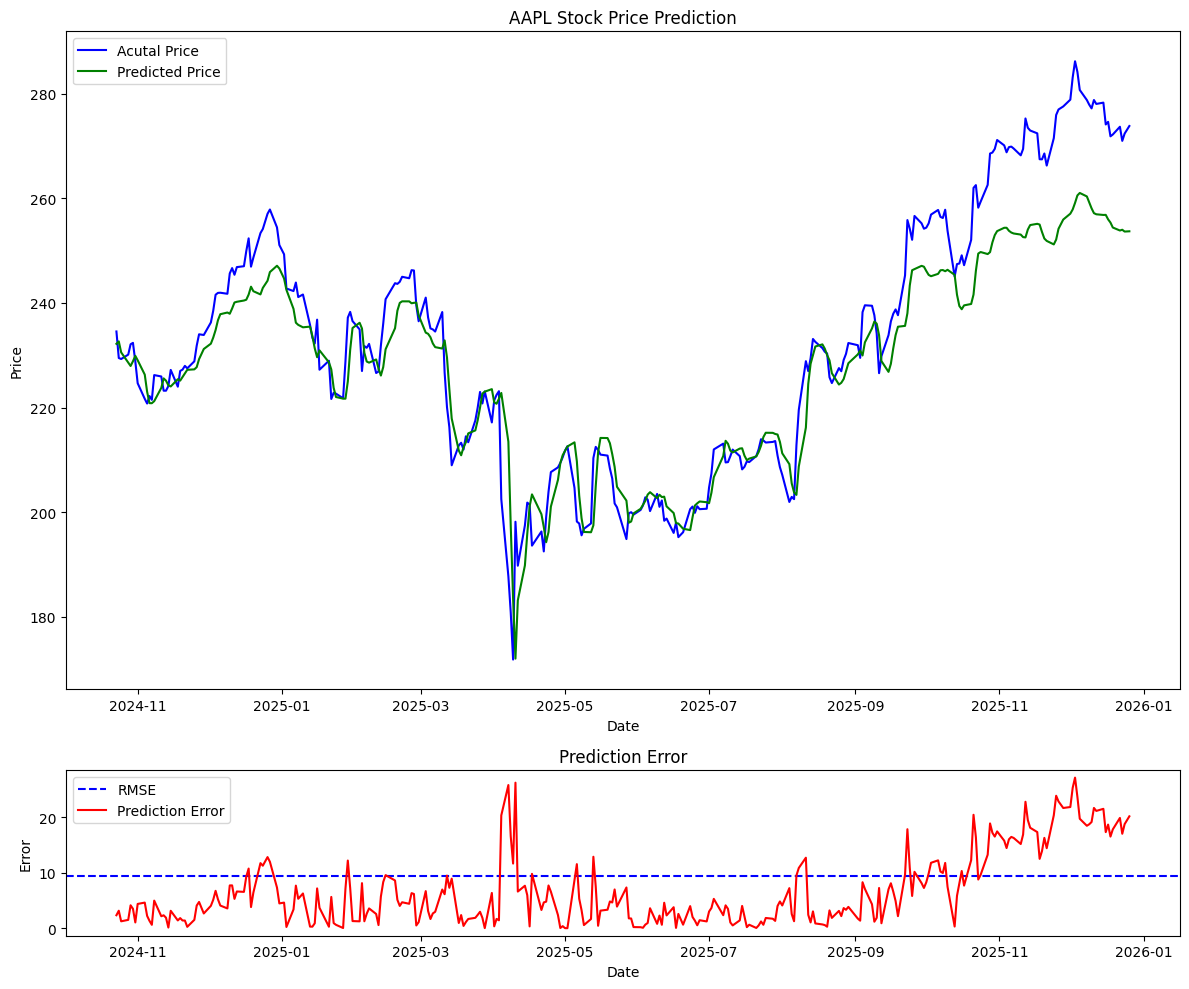

In [39]:
fig = plt.figure(figsize=(12,10))

gs = fig.add_gridspec(4,1)

ax1 = fig.add_subplot(gs[:3,0])
ax1.plot(df.iloc[-len(y_test):].index, y_test, color='blue', label = 'Acutal Price')
ax1.plot(df.iloc[-len(y_test):].index, y_test_pred, color='green', label = 'Predicted Price')
ax1.legend()
plt.title(f"{ticker} Stock Price Prediction")
plt.xlabel('Date')
plt.ylabel('Price')

ax2 = fig.add_subplot(gs[3,0])
ax2.axhline(test_rmse, color='blue', linestyle='--', label = 'RMSE')
ax2.plot(df[-len(y_test):].index, abs(y_test-y_test_pred), 'r', label="Prediction Error")
ax2.legend()
plt.title('Prediction Error')
plt.xlabel('Date')
plt.ylabel('Error')
plt.tight_layout()
plt.show()
